**Case Study #1**


Dataset location
https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

Install Required PIP modules 

In [1]:
%pip install kagglehub 
%pip install numpy pandas matplotlib seaborn scikit-learn scikit-image tqdm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Load python modules

In [2]:
# Load Modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Download the dataset and move it to the "data" folder

In [3]:
import os
import kagglehub
import shutil
import tqdm

# Create data directory if it doesn't exist
os.makedirs("./data", exist_ok=True)

# Download the dataset (this will go to a temporary location)
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")

# Move the downloaded file to your desired location
path = path+"/WA_Fn-UseC_-HR-Employee-Attrition.csv"
shutil.copy(path, "./data/ibm_hr_dataset.csv")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'./data/ibm_hr_dataset.csv'

Load the dataset into Pandas and convert categories to numeric representations

In [4]:
"""Load and prepare the IBM HR Analytics dataset"""
df = pd.read_csv('./data/ibm_hr_dataset.csv')

# Convert categorical variables to numeric
categorical_columns = ['BusinessTravel', 'Department', 'EducationField', 
                        'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

df, df_encoded

(      Age Attrition     BusinessTravel  DailyRate              Department  \
 0      41       Yes      Travel_Rarely       1102                   Sales   
 1      49        No  Travel_Frequently        279  Research & Development   
 2      37       Yes      Travel_Rarely       1373  Research & Development   
 3      33        No  Travel_Frequently       1392  Research & Development   
 4      27        No      Travel_Rarely        591  Research & Development   
 ...   ...       ...                ...        ...                     ...   
 1465   36        No  Travel_Frequently        884  Research & Development   
 1466   39        No      Travel_Rarely        613  Research & Development   
 1467   27        No      Travel_Rarely        155  Research & Development   
 1468   49        No  Travel_Frequently       1023                   Sales   
 1469   34        No      Travel_Rarely        628  Research & Development   
 
       DistanceFromHome  Education EducationField  EmployeeCou

# Prepare features and target variables and identify columns with missing values.
Fill the missing values with the median of the column.
Split the data into training and testing sets.
Scale the features using StandardScaler.

In [5]:
"""Prepare features and target variables"""
# First, ensure Attrition is properly encoded before dropping it
df_encoded['Attrition'] = df_encoded['Attrition'].map({'Yes': 1, 'No': 0})
df_encoded = df_encoded.drop('Over18', axis=1)

# Now prepare X and y
X = df_encoded.drop(['Attrition'], axis=1)
y = df_encoded['Attrition']

# Convert any remaining object columns to numeric
for column in X.select_dtypes(include=['object']).columns:
    X[column] = pd.to_numeric(X[column], errors='coerce')

# Check for and handle missing values
print("Columns with missing values:")
print(X.isnull().sum()[X.isnull().sum() > 0])

# Fill missing values with the median of each column
X = X.fillna(X.median())

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Columns with missing values:
Series([], dtype: int64)


Generate plots of data, Work-Life Balance vs Monthly Income, Job Satisfaction vs Attrition, and Years at Company vs Job Level.

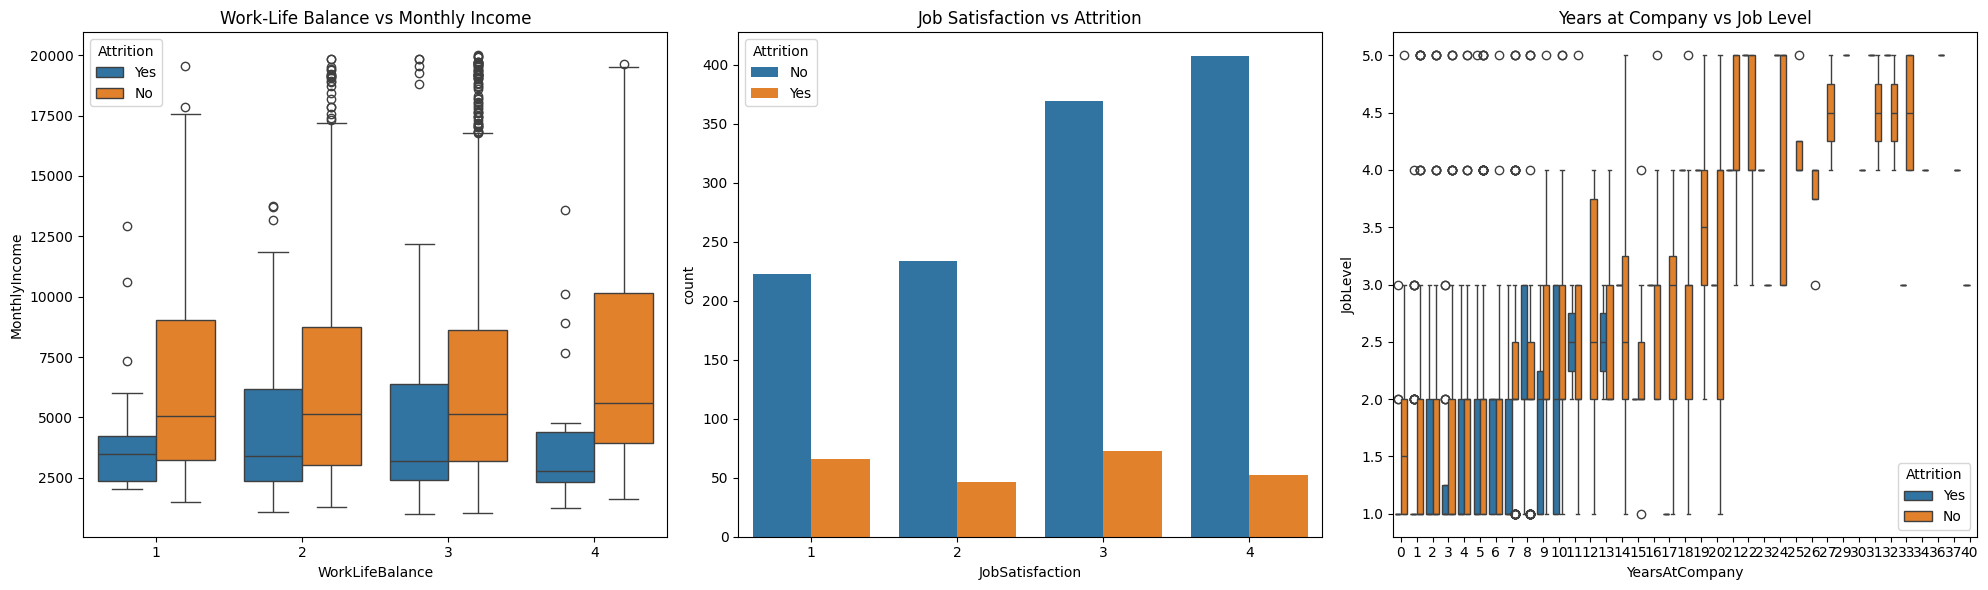

In [6]:
"""Analyze and visualize work-related factors"""
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='WorkLifeBalance', y='MonthlyIncome', hue='Attrition', data=df)
plt.title('Work-Life Balance vs Monthly Income')

plt.subplot(1, 3, 2)
sns.countplot(x='JobSatisfaction', hue='Attrition', data=df)
plt.title('Job Satisfaction vs Attrition')

plt.subplot(1, 3, 3)
sns.boxplot(x='YearsAtCompany', y='JobLevel', hue='Attrition', data=df)
plt.title('Years at Company vs Job Level')

plt.tight_layout()
plt.show()


Show plots for demographic factors, Age Distribution by Attrition, Marital Status vs Attrition and Department vs Attrition.

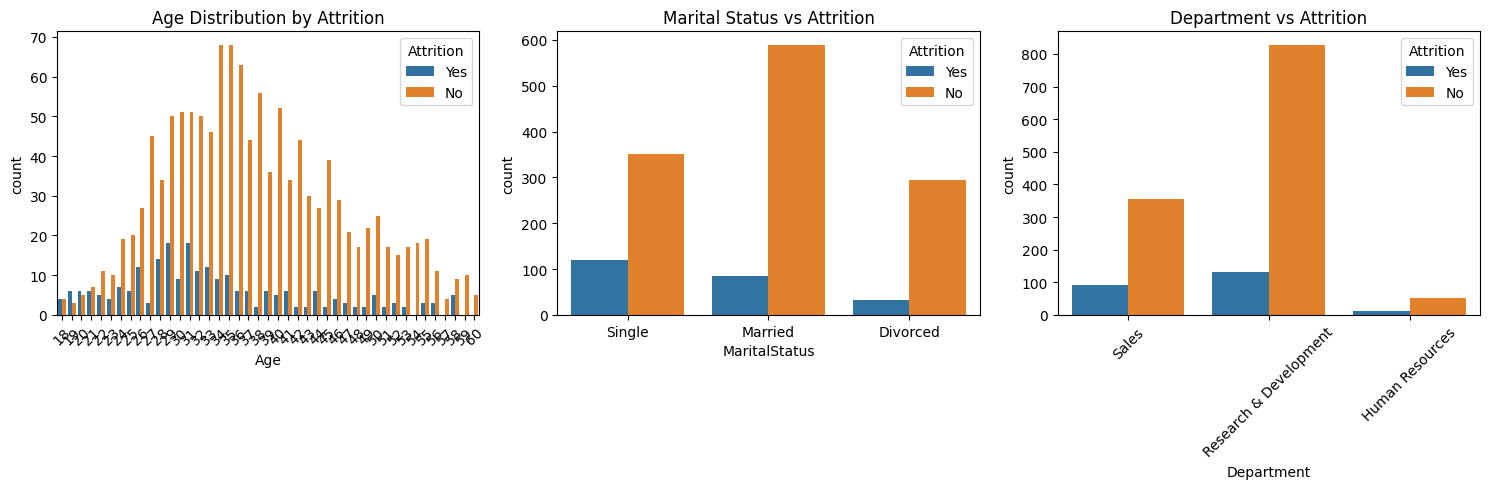

In [7]:
"""Analyze and visualize demographic factors"""
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x='Age', hue='Attrition', data=df)
plt.title('Age Distribution by Attrition')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.countplot(x='MaritalStatus', hue='Attrition', data=df)
plt.title('Marital Status vs Attrition')

plt.subplot(1, 3, 3)
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title('Department vs Attrition')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Now that we have our data ready, we can train a Random Forest Model. and evaluate the classification performance.

In [8]:
"""Train Random Forest Model"""
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Print model performance metrics
print("Model Performance Metrics:")
print("\nClassification Report:")
y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Model Performance Metrics:

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       255
           1       0.80      0.10      0.18        39

    accuracy                           0.88       294
   macro avg       0.84      0.55      0.56       294
weighted avg       0.87      0.88      0.83       294



Here we work on determining the most important features that influence attrition, and find that Monthly Income, Age, and Total Working Years are the most important.

In [9]:
"""Calculate feature importance"""
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance.head(10))

Top 10 Most Important Features:
              feature  importance
11      MonthlyIncome    0.066889
0                 Age    0.050471
19  TotalWorkingYears    0.047649
1           DailyRate    0.046277
5      EmployeeNumber    0.044830
53       OverTime_Yes    0.043989
12        MonthlyRate    0.042751
7          HourlyRate    0.040232
2    DistanceFromHome    0.040149
22     YearsAtCompany    0.036758


We start looking at defining some recommendations based on the data analysis.

In [10]:
def generate_recommendations(df, feature_importance):
    """Generate HR recommendations based on data analysis"""
    
    # Get top factors influencing attrition
    top_factors = feature_importance.head(3)['feature'].tolist()
    
    # Calculate key metrics
    avg_satisfaction = df['JobSatisfaction'].mean()
    attrition_rate = (df['Attrition'] == 'Yes').mean() * 100
    overtime_impact = df[df['OverTime'] == 'Yes']['Attrition'].value_counts(normalize=True).get('Yes', 0) * 100
    
    recommendations = []
    
    # Data-driven recommendations based on top factors
    recommendations.append("Key Focus Areas (based on top predictive factors):")
    for factor in top_factors:
        recommendations.append(f"- Address {factor} as it's among the top factors influencing attrition")
    
    # Specific recommendations based on metrics
    recommendations.append("\nMetrics-based Recommendations:")
    
    if avg_satisfaction < 3:  # Assuming satisfaction is on a 1-4 scale
        recommendations.append("- Priority: Improve job satisfaction through:")
        recommendations.append("  * Regular feedback sessions")
        recommendations.append("  * Career development opportunities")
    
    if overtime_impact > 20:  # If attrition is 20% higher among overtime workers
        recommendations.append("- Address work-life balance:")
        recommendations.append("  * Review overtime policies")
        recommendations.append("  * Consider additional staffing")
    
    if attrition_rate > 15:  # If overall attrition is above 15%
        recommendations.append("- Implement retention strategies:")
        recommendations.append("  * Competitive compensation review")
        recommendations.append("  * Enhanced benefits package")
    
    return "\n".join(recommendations)

Here we return our recommendations.

In [11]:
"""Generate recommendations based on analysis"""
recommendations = generate_recommendations(df, feature_importance)
print("HR Recommendations Based on Data Analysis:")
print(recommendations)

HR Recommendations Based on Data Analysis:
Key Focus Areas (based on top predictive factors):
- Address MonthlyIncome as it's among the top factors influencing attrition
- Address Age as it's among the top factors influencing attrition
- Address TotalWorkingYears as it's among the top factors influencing attrition

Metrics-based Recommendations:
- Priority: Improve job satisfaction through:
  * Regular feedback sessions
  * Career development opportunities
- Address work-life balance:
  * Review overtime policies
  * Consider additional staffing
- Implement retention strategies:
  * Competitive compensation review
  * Enhanced benefits package


We see here monthly income, age, and total working years are the top 3 factors influencing attrition.

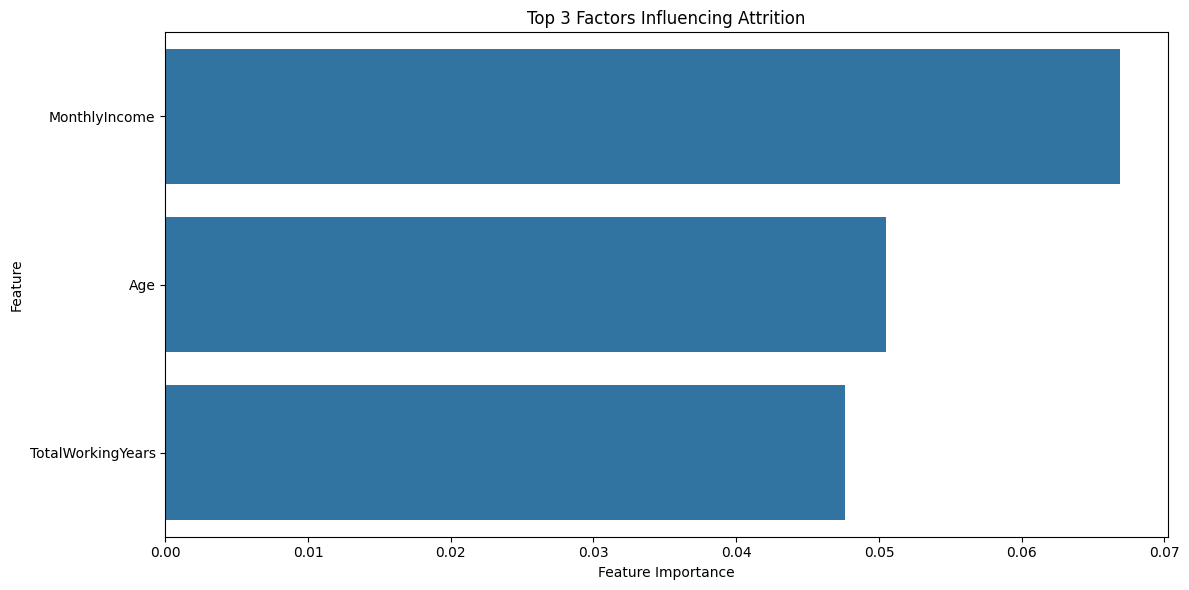

In [12]:
"""Visualize top factors influencing attrition"""
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(3), x='importance', y='feature')
plt.title('Top 3 Factors Influencing Attrition')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This shows the importanace of Each top factor and the detailed analysis of each factor.

In [13]:
"""Analyze top factors in detail"""
def analyze_top_factors(df, feature_importance, n_factors=3):
    top_factors = feature_importance.head(n_factors)
    detailed_analysis = []
    
    for _, row in top_factors.iterrows():
        factor = row['feature']
        importance = row['importance']
        
        detailed_analysis.append(f"\n=== Analysis of {factor} (Importance: {importance:.3f}) ===")
        
        if factor in df.columns:  # Ensure factor exists in original dataframe
            # Basic statistics
            stats = df.groupby('Attrition')[factor].agg(['mean', 'median', 'std']).round(2)
            detailed_analysis.append("\nStatistics by Attrition Status:")
            detailed_analysis.append(str(stats))
            
            # Distribution comparison
            detailed_analysis.append("\nDistribution Analysis:")
            if df[factor].nunique() <= 10:  # Categorical or discrete variable
                dist = df.groupby(factor)['Attrition'].value_counts(normalize=True).unstack()
                detailed_analysis.append(str(dist.round(3)))
            else:  # Continuous variable
                for attrition in ['Yes', 'No']:
                    subset = df[df['Attrition'] == attrition][factor]
                    detailed_analysis.append(f"\n{attrition} - Percentiles:")
                    detailed_analysis.append(str(subset.quantile([0.25, 0.5, 0.75]).round(2)))
    
    return "\n".join(detailed_analysis)

# Print detailed analysis
print(analyze_top_factors(df, feature_importance))


=== Analysis of MonthlyIncome (Importance: 0.067) ===

Statistics by Attrition Status:
              mean  median      std
Attrition                          
No         6832.74  5204.0  4818.21
Yes        4787.09  3202.0  3640.21

Distribution Analysis:

Yes - Percentiles:
0.25    2373.0
0.50    3202.0
0.75    5916.0
Name: MonthlyIncome, dtype: float64

No - Percentiles:
0.25    3211.0
0.50    5204.0
0.75    8834.0
Name: MonthlyIncome, dtype: float64

=== Analysis of Age (Importance: 0.050) ===

Statistics by Attrition Status:
            mean  median   std
Attrition                     
No         37.56    36.0  8.89
Yes        33.61    32.0  9.69

Distribution Analysis:

Yes - Percentiles:
0.25    28.0
0.50    32.0
0.75    39.0
Name: Age, dtype: float64

No - Percentiles:
0.25    31.0
0.50    36.0
0.75    43.0
Name: Age, dtype: float64

=== Analysis of TotalWorkingYears (Importance: 0.048) ===

Statistics by Attrition Status:
            mean  median   std
Attrition                

Here is a visualization of the relationships between the top factors.

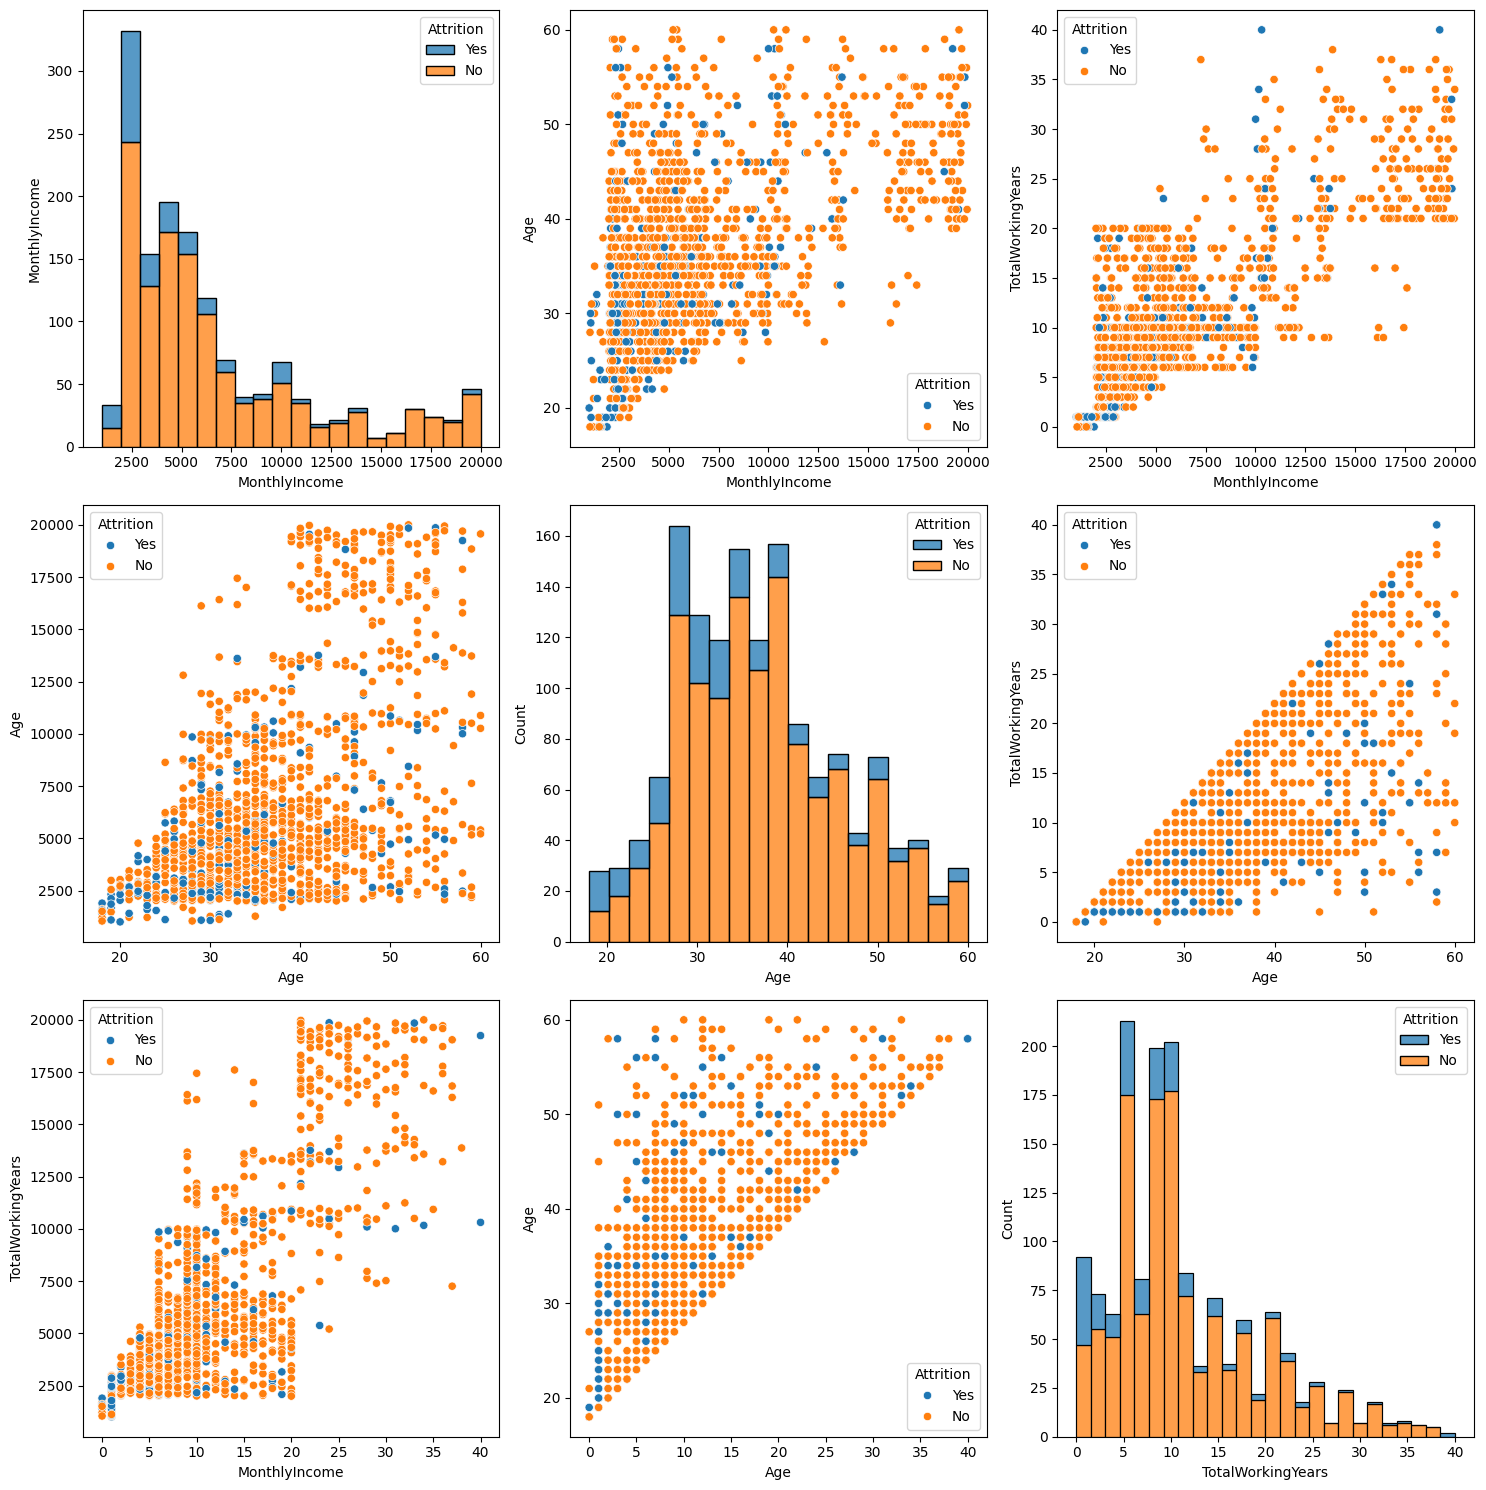

In [14]:
"""Visualize relationships between top factors"""
def visualize_factor_relationships(df, feature_importance, n_factors=3):
    top_factors = feature_importance.head(n_factors)['feature'].tolist()
    
    # Create subplots for each pair of top factors
    fig, axes = plt.subplots(n_factors, n_factors, figsize=(15, 15))
    
    for i, factor1 in enumerate(top_factors):
        for j, factor2 in enumerate(top_factors):
            if i != j:
                # Scatter plot for continuous variables
                sns.scatterplot(data=df, x=factor1, y=factor2, 
                              hue='Attrition', ax=axes[i, j])
            else:
                # Distribution plot for single variable
                sns.histplot(data=df, x=factor1, hue='Attrition', 
                           multiple="stack", ax=axes[i, i])
            
            if i == n_factors-1:
                axes[i, j].set_xlabel(factor2)
            if j == 0:
                axes[i, j].set_ylabel(factor1)
                
    plt.tight_layout()
    plt.show()

visualize_factor_relationships(df, feature_importance)

In [15]:
"""Perform statistical tests on top factors"""
def statistical_analysis(df, feature_importance, n_factors=3):
    from scipy import stats
    top_factors = feature_importance.head(n_factors)['feature'].tolist()
    analysis_results = []
    
    for factor in top_factors:
        analysis_results.append(f"\n=== Statistical Analysis for {factor} ===")
        
        # Split data by attrition
        yes_group = df[df['Attrition'] == 'Yes'][factor]
        no_group = df[df['Attrition'] == 'No'][factor]
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(yes_group, no_group)
        analysis_results.append(f"T-test p-value: {p_value:.4f}")
        
        # Effect size (Cohen's d)
        d = (yes_group.mean() - no_group.mean()) / np.sqrt((yes_group.var() + no_group.var()) / 2)
        analysis_results.append(f"Effect size (Cohen's d): {d:.4f}")
        
        # Correlation with other factors
        correlations = df[top_factors].corr()[factor].sort_values(ascending=False)
        analysis_results.append("\nTop correlations:")
        analysis_results.append(str(correlations.round(3)))
    
    return "\n".join(analysis_results)

print(statistical_analysis(df, feature_importance))


=== Statistical Analysis for MonthlyIncome ===
T-test p-value: 0.0000
Effect size (Cohen's d): -0.4791

Top correlations:
MonthlyIncome        1.000
TotalWorkingYears    0.773
Age                  0.498
Name: MonthlyIncome, dtype: float64

=== Statistical Analysis for Age ===
T-test p-value: 0.0000
Effect size (Cohen's d): -0.4252

Top correlations:
Age                  1.000
TotalWorkingYears    0.680
MonthlyIncome        0.498
Name: Age, dtype: float64

=== Statistical Analysis for TotalWorkingYears ===
T-test p-value: 0.0000
Effect size (Cohen's d): -0.4843

Top correlations:
TotalWorkingYears    1.000
MonthlyIncome        0.773
Age                  0.680
Name: TotalWorkingYears, dtype: float64


Career progression analysis

In [16]:
"""Analyze career progression patterns"""
def analyze_career_progression(df):
    progression = []
    
    # Time to promotion analysis
    progression.append("\n=== Career Progression Metrics ===")
    df['PromotionRate'] = df['YearsSinceLastPromotion'] / df['YearsAtCompany']
    
    for dept in df['Department'].unique():
        dept_data = df[df['Department'] == dept]
        progression.append(f"\n{dept} Department:")
        progression.append(f"Average years to promotion: {dept_data['YearsSinceLastPromotion'].mean():.1f}")
        progression.append(f"Promotion rate: {dept_data['PromotionRate'].mean():.2%}")
    
    return "\n".join(progression)

print(analyze_career_progression(df))


=== Career Progression Metrics ===

Sales Department:
Average years to promotion: 2.4
Promotion rate: 31.88%

Research & Development Department:
Average years to promotion: 2.1
Promotion rate: 29.15%

Human Resources Department:
Average years to promotion: 1.8
Promotion rate: 28.01%


Work-Life Balance analysis

In [17]:
"""Analyze work-life balance factors"""
def analyze_work_life_balance(df):
    analysis = []
    
    # Overtime analysis
    analysis.append("\n=== Work-Life Balance Analysis ===")
    overtime_impact = pd.crosstab(
        df['OverTime'], 
        df['Attrition'], 
        normalize='index'
    )
    analysis.append("\nOvertime Impact on Attrition:")
    analysis.append(str(overtime_impact))
    
    # Distance from home analysis
    analysis.append("\nDistance From Home Impact:")
    distance_groups = pd.qcut(df['DistanceFromHome'], q=4, labels=['Close', 'Medium', 'Far', 'Very Far'])
    distance_impact = pd.crosstab(
        distance_groups,
        df['Attrition'],
        normalize='index'
    )
    analysis.append(str(distance_impact))
    
    return "\n".join(analysis)

print(analyze_work_life_balance(df))


=== Work-Life Balance Analysis ===

Overtime Impact on Attrition:
Attrition        No       Yes
OverTime                     
No         0.895636  0.104364
Yes        0.694712  0.305288

Distance From Home Impact:
Attrition               No       Yes
DistanceFromHome                    
Close             0.871122  0.128878
Medium            0.856742  0.143258
Far               0.826471  0.173529
Very Far          0.794366  0.205634


Looking at compensation patterns and fairness, we can see that there is a disparity in salary between genders that may need further investigation and correction, as well as a correlation between experience and salary, with some outliers that may need further investigation.

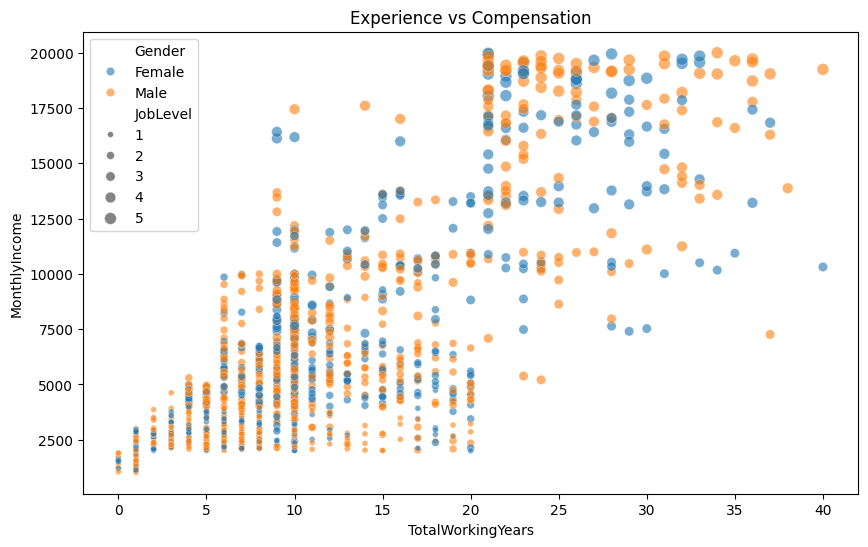


=== Compensation Equity Analysis ===

Gender Pay Analysis by Job Level:
                     mean  count
JobLevel Gender                 
1        Female   2780.49    199
         Male     2790.63    344
2        Female   5435.33    220
         Male     5549.18    314
3        Female   9962.70     94
         Male     9706.99    124
4        Female  15431.37     51
         Male    15570.93     55
5        Female  19129.92     24
         Male    19224.84     45


In [18]:
"""Analyze compensation patterns and fairness"""
def analyze_compensation(df):
    analysis = []
    
    # Salary equity analysis
    analysis.append("\n=== Compensation Equity Analysis ===")
    
    # Gender pay analysis
    gender_pay = df.groupby(['JobLevel', 'Gender'])['MonthlyIncome'].agg(['mean', 'count']).round(2)
    analysis.append("\nGender Pay Analysis by Job Level:")
    analysis.append(str(gender_pay))
    
    # Experience vs compensation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='TotalWorkingYears', y='MonthlyIncome', 
                    hue='Gender', size='JobLevel', alpha=0.6)
    plt.title('Experience vs Compensation')
    plt.show()
    
    return "\n".join(analysis)

print(analyze_compensation(df))

=== WorkLifeBalance Distribution ===
WorkLifeBalance
1     80
2    344
3    893
4    153
Name: count, dtype: int64

Value counts (percentage):
WorkLifeBalance
1     5.4
2    23.4
3    60.7
4    10.4
Name: proportion, dtype: float64 %


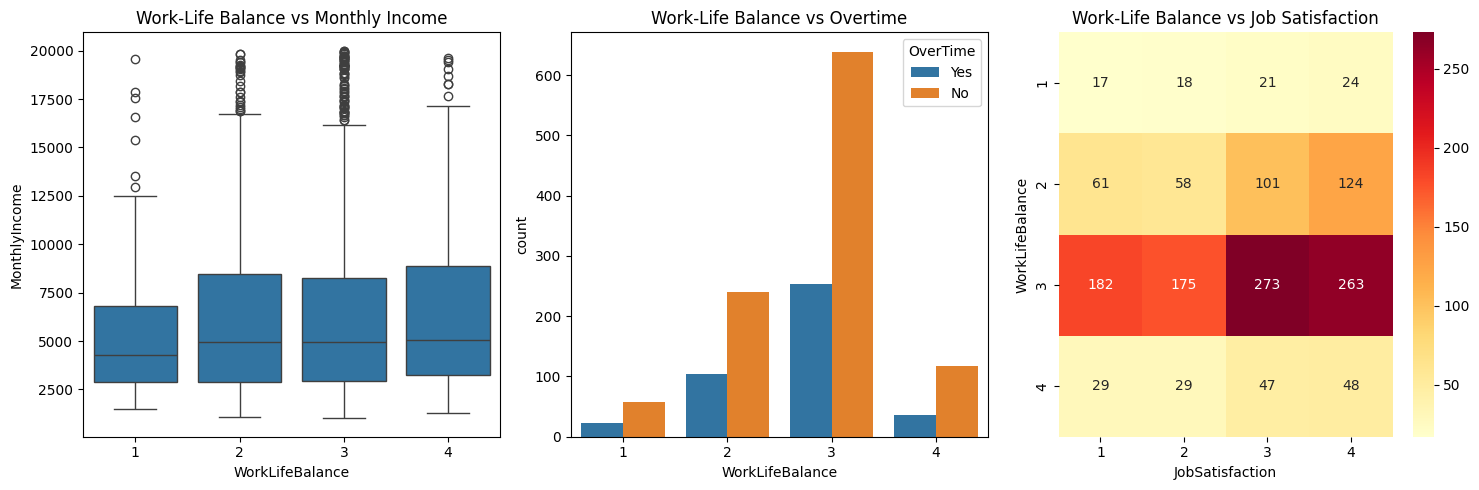


=== Work-Life Balance by Department ===
WorkLifeBalance          1    2    3   4
Department                              
Human Resources          4    7   42  10
Research & Development  60  235  575  91
Sales                   16  102  276  52

=== Average Monthly Income by Work-Life Balance ===
WorkLifeBalance
1    5887.14
2    6461.81
3    6532.23
4    6746.35
Name: MonthlyIncome, dtype: float64

=== Attrition Rate by Work-Life Balance ===
WorkLifeBalance
1    31.2
2    16.9
3    14.2
4    17.6
Name: Yes, dtype: float64 %


In [19]:
"""Analyze WorkLifeBalance variable in detail"""
# Basic distribution
print("=== WorkLifeBalance Distribution ===")
print(df['WorkLifeBalance'].value_counts().sort_index())
print("\nValue counts (percentage):")
print(df['WorkLifeBalance'].value_counts(normalize=True).sort_index().round(3) * 100, "%")

# Relationship with other variables
plt.figure(figsize=(15, 5))

# Work-Life Balance vs Monthly Income
plt.subplot(1, 3, 1)
sns.boxplot(x='WorkLifeBalance', y='MonthlyIncome', data=df)
plt.title('Work-Life Balance vs Monthly Income')

# Work-Life Balance vs Overtime
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='WorkLifeBalance', hue='OverTime')
plt.title('Work-Life Balance vs Overtime')

# Work-Life Balance vs Job Satisfaction
plt.subplot(1, 3, 3)
sns.heatmap(pd.crosstab(df['WorkLifeBalance'], df['JobSatisfaction']), 
            annot=True, fmt='d', cmap='YlOrRd')
plt.title('Work-Life Balance vs Job Satisfaction')

plt.tight_layout()
plt.show()

# Additional analysis
print("\n=== Work-Life Balance by Department ===")
print(pd.crosstab(df['Department'], df['WorkLifeBalance']))

print("\n=== Average Monthly Income by Work-Life Balance ===")
print(df.groupby('WorkLifeBalance')['MonthlyIncome'].mean().round(2))

print("\n=== Attrition Rate by Work-Life Balance ===")
attrition_by_wlb = pd.crosstab(df['WorkLifeBalance'], df['Attrition'], normalize='index')
print(attrition_by_wlb['Yes'].round(3) * 100, "%")

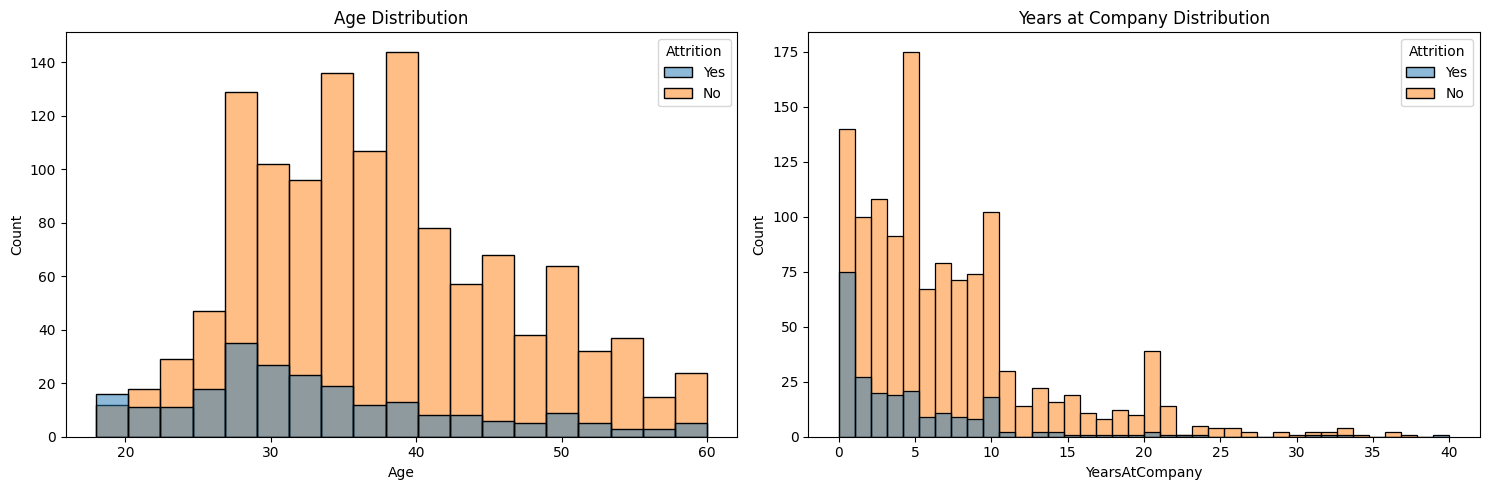

In [20]:
# Check for unusual distributions or patterns
# Age distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Age', hue='Attrition')
plt.title('Age Distribution')


# Years at company
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='YearsAtCompany', hue='Attrition')
plt.title('Years at Company Distribution')

plt.tight_layout()
plt.show()

Salary distribution by job level and gender, and experience vs salary.  This shows there is a disparity in salary between genders that may need further investigation and correction.

Looking at experience vs salary, we can see that there is a correlation between experience and salary.  This is expected as experience is a key factor in salary, but there are some outliers that may need further investigation.

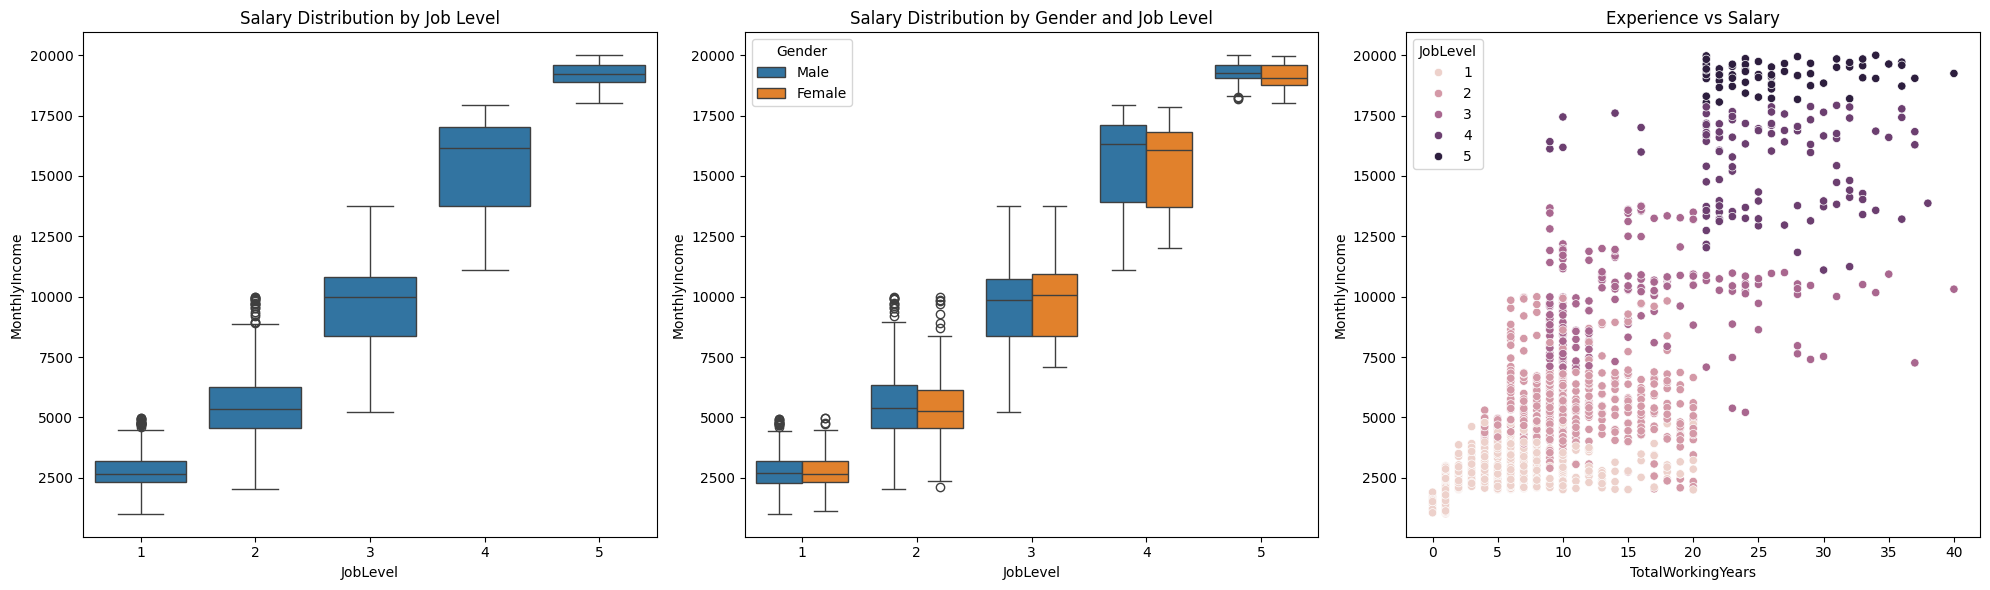

In [21]:
plt.figure(figsize=(20, 6))

# Salary by Job Level
plt.subplot(1, 3, 1)
sns.boxplot(x='JobLevel', y='MonthlyIncome', data=df)
plt.title('Salary Distribution by Job Level')

# Gender Pay Analysis
plt.subplot(1, 3, 2)
sns.boxplot(x='JobLevel', y='MonthlyIncome', hue='Gender', data=df)
plt.title('Salary Distribution by Gender and Job Level')

# Experience vs Salary
plt.subplot(1, 3, 3)
sns.scatterplot(x='TotalWorkingYears', y='MonthlyIncome', hue='JobLevel', data=df)
plt.title('Experience vs Salary')

plt.tight_layout()
plt.show()

Work-Life Balance distribution, overtime impact, and correlation between work-life balance and satisfaction.

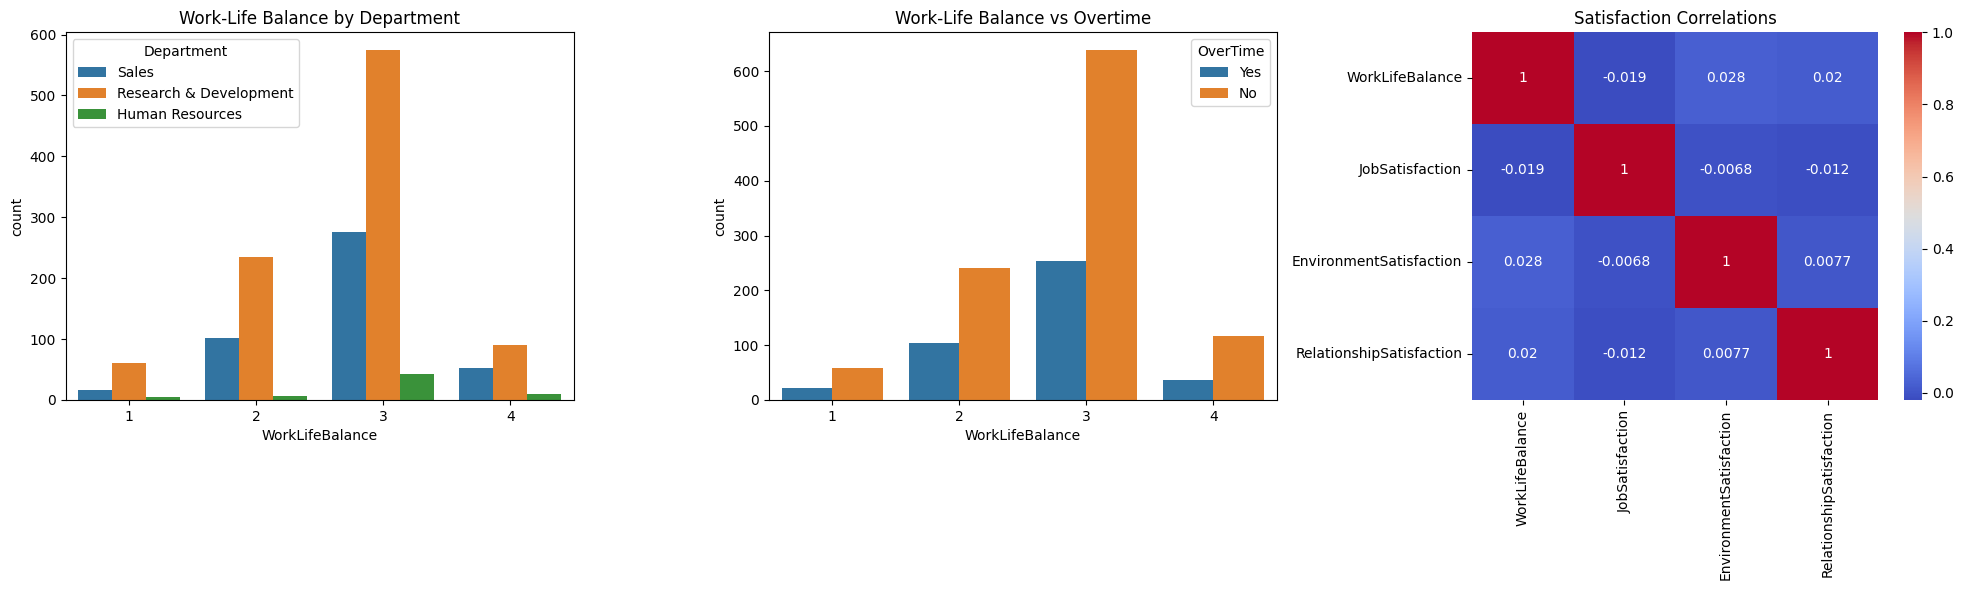

In [22]:
plt.figure(figsize=(20, 6))

# Work-Life Balance Distribution
plt.subplot(1, 3, 1)
sns.countplot(x='WorkLifeBalance', hue='Department', data=df)
plt.title('Work-Life Balance by Department')

# Overtime Impact
plt.subplot(1, 3, 2)
sns.countplot(x='WorkLifeBalance', hue='OverTime', data=df)
plt.title('Work-Life Balance vs Overtime')

# Satisfaction Correlation
plt.subplot(1, 3, 3)
satisfaction_corr = df[['WorkLifeBalance', 'JobSatisfaction', 
                       'EnvironmentSatisfaction', 'RelationshipSatisfaction']].corr()
sns.heatmap(satisfaction_corr, annot=True, cmap='coolwarm')
plt.title('Satisfaction Correlations')

plt.tight_layout()
plt.show()

Attrition by department and satisfaction by department

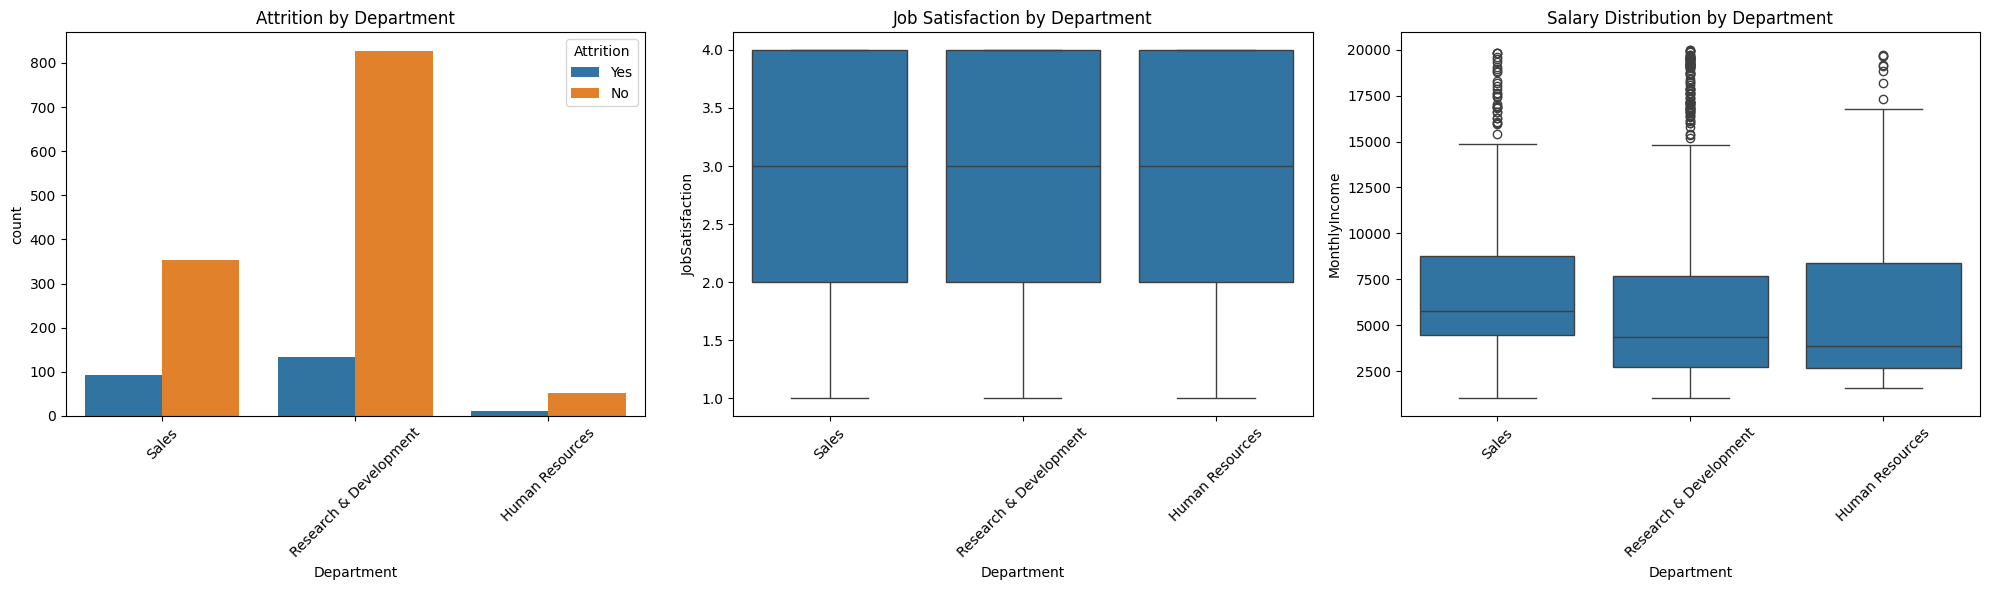

In [23]:
plt.figure(figsize=(20, 6))

# Attrition by Department
plt.subplot(1, 3, 1)
sns.countplot(x='Department', hue='Attrition', data=df)
plt.xticks(rotation=45)
plt.title('Attrition by Department')

# Satisfaction by Department
plt.subplot(1, 3, 2)
sns.boxplot(x='Department', y='JobSatisfaction', data=df)
plt.xticks(rotation=45)
plt.title('Job Satisfaction by Department')

# Monthly Income by Department
plt.subplot(1, 3, 3)
sns.boxplot(x='Department', y='MonthlyIncome', data=df)
plt.xticks(rotation=45)
plt.title('Salary Distribution by Department')

plt.tight_layout()
plt.show()

Create a risk profile of what a high risk employee is.

=== High Risk Employee Profile ===
Number of high-risk employees: 303
Average risk score: 59.55%

Key Characteristics of High-Risk Employees:
- Average Age: 34.2 years
- Average Monthly Income: $5062.34
- Average Years at Company: 5.4

Most Common Departments:
Department
Research & Development    175
Sales                     112
Human Resources            16
Name: count, dtype: int64

Overtime Status:
OverTime
Yes    54.8%
No     45.2%
Name: proportion, dtype: object


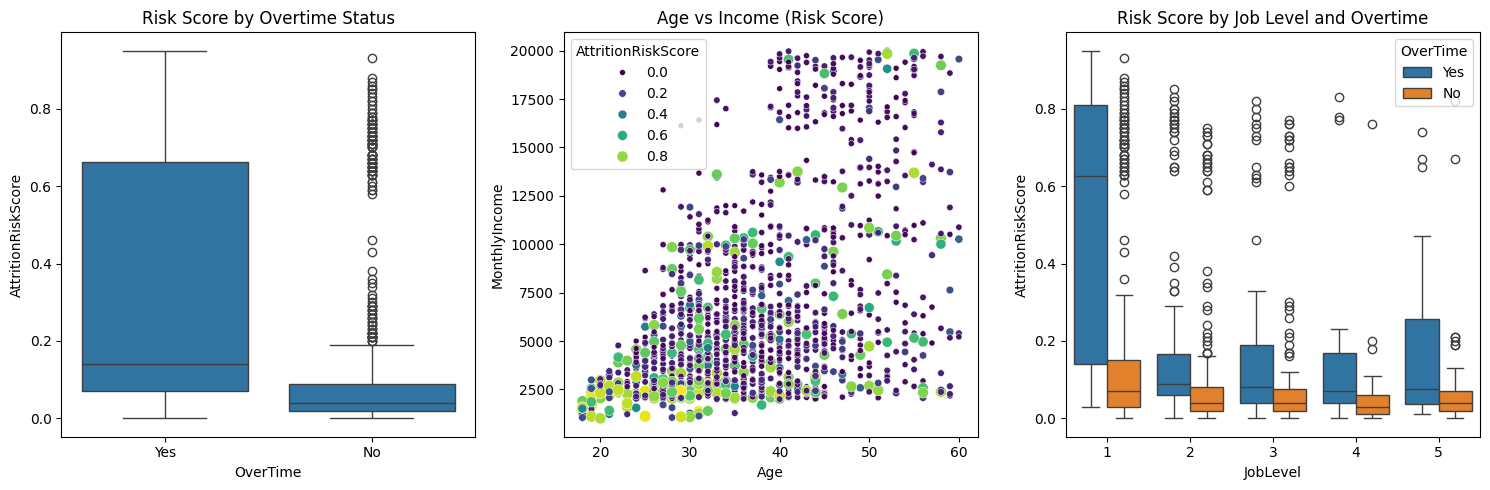

In [24]:
def identify_high_risk_employees(df, df_encoded, rf_model, scaler, feature_importance):
    """Identify and analyze employees with high attrition risk"""
    
    # Ensure all categorical variables are encoded
    # Identify non-numeric columns in df_encoded
    non_numeric_cols = df_encoded.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        print("Encoding the following non-numeric columns:", non_numeric_cols)
        # Convert categorical variables to numeric using label encoding or one-hot encoding
        for col in non_numeric_cols:
            df_encoded[col] = df_encoded[col].astype('category').cat.codes
    
    # Prepare features (using already encoded dataframe)
    X_full = df_encoded.drop(['Attrition'], axis=1)
    
    # Ensure that the columns match the ones used during training
    missing_cols = set(X_train.columns) - set(X_full.columns)
    for col in missing_cols:
        X_full[col] = 0  # Add missing columns with default value 0
    X_full = X_full[X_train.columns]  # Ensure the same column order
    
    # Scale the features using the existing scaler
    X_full_scaled = scaler.transform(X_full)
    
    # Get attrition probabilities for all employees
    attrition_prob = rf_model.predict_proba(X_full_scaled)[:, 1]
    
    # Add probability scores to original dataframe
    df_risk = df.copy()
    df_risk['AttritionRiskScore'] = attrition_prob
    
    # Define high risk threshold (top 20% of risk scores)
    high_risk_threshold = df_risk['AttritionRiskScore'].quantile(0.8)
    high_risk_employees = df_risk[df_risk['AttritionRiskScore'] >= high_risk_threshold]
    
    # Analyze characteristics of high-risk employees
    print("=== High Risk Employee Profile ===")
    print(f"Number of high-risk employees: {len(high_risk_employees)}")
    print(f"Average risk score: {high_risk_employees['AttritionRiskScore'].mean():.2%}")
    
    print("\nKey Characteristics of High-Risk Employees:")
    print(f"- Average Age: {high_risk_employees['Age'].mean():.1f} years")
    print(f"- Average Monthly Income: ${high_risk_employees['MonthlyIncome'].mean():.2f}")
    print(f"- Average Years at Company: {high_risk_employees['YearsAtCompany'].mean():.1f}")
    
    print("\nMost Common Departments:")
    print(high_risk_employees['Department'].value_counts().head(3))
    
    print("\nOvertime Status:")
    print((high_risk_employees['OverTime'].value_counts(normalize=True) * 100).round(1).astype(str) + '%')
    
    # Visualize key factors for high-risk employees
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.boxplot(data=df_risk, x='OverTime', y='AttritionRiskScore')
    plt.title('Risk Score by Overtime Status')
    
    plt.subplot(1, 3, 2)
    sns.scatterplot(data=df_risk, x='Age', y='MonthlyIncome', 
                    hue='AttritionRiskScore', size='AttritionRiskScore', palette='viridis')
    plt.title('Age vs Income (Risk Score)')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(data=df_risk, x='JobLevel', y='AttritionRiskScore', hue='OverTime')
    plt.title('Risk Score by Job Level and Overtime')
    
    plt.tight_layout()
    plt.show()
    
    return high_risk_employees

# Now we need to make sure we have the scaler and X_train used during training
# Assuming you have these from your earlier model training:
# scaler, X_train

# Calculate risk scores and analyze
high_risk_df = identify_high_risk_employees(df, df_encoded, rf_model, scaler, feature_importance)

Identify specifichigh risk employees within the data and the likely factors that contribute to their risk.

In [25]:
# Create a risk profile DataFrame
risk_profile = df.copy()

# Calculate risk score based on key factors
risk_factors = {
    'OverTime': {'Yes': 1, 'No': 0},  # Working overtime increases risk
    'JobSatisfaction': {1: 1, 2: 0.75, 3: 0.25, 4: 0},  # Lower satisfaction = higher risk
    'WorkLifeBalance': {1: 1, 2: 0.75, 3: 0.25, 4: 0},  # Poor work-life balance = higher risk
    'YearsSinceLastPromotion': 5,  # Threshold for promotion concerns
    'MonthlyIncome': None,  # Will be calculated based on job level median
    'EnvironmentSatisfaction': {1: 1, 2: 0.75, 3: 0.25, 4: 0}  # Lower satisfaction = higher risk
}

# Calculate risk scores
risk_profile['OverTimeRisk'] = risk_profile['OverTime'].map(risk_factors['OverTime'])
risk_profile['JobSatisfactionRisk'] = risk_profile['JobSatisfaction'].map(risk_factors['JobSatisfaction'])
risk_profile['WorkLifeBalanceRisk'] = risk_profile['WorkLifeBalance'].map(risk_factors['WorkLifeBalance'])
risk_profile['EnvironmentRisk'] = risk_profile['EnvironmentSatisfaction'].map(risk_factors['EnvironmentSatisfaction'])

# Calculate salary risk (compared to job level median)
for level in risk_profile['JobLevel'].unique():
    level_median = risk_profile[risk_profile['JobLevel'] == level]['MonthlyIncome'].median()
    mask = (risk_profile['JobLevel'] == level) & (risk_profile['MonthlyIncome'] < level_median)
    risk_profile.loc[mask, 'SalaryRisk'] = 1
    risk_profile.loc[~mask, 'SalaryRisk'] = 0

# Calculate promotion risk
risk_profile['PromotionRisk'] = (risk_profile['YearsSinceLastPromotion'] > risk_factors['YearsSinceLastPromotion']).astype(int)

# Calculate overall risk score (weighted average)
weights = {
    'OverTimeRisk': 0.2,
    'JobSatisfactionRisk': 0.2,
    'WorkLifeBalanceRisk': 0.15,
    'EnvironmentRisk': 0.15,
    'SalaryRisk': 0.15,
    'PromotionRisk': 0.15
}

risk_profile['TotalRiskScore'] = sum(risk_profile[risk] * weight for risk, weight in weights.items())

# Identify high-risk employees (top 20%)
risk_threshold = risk_profile['TotalRiskScore'].quantile(0.8)
high_risk_employees = risk_profile[risk_profile['TotalRiskScore'] >= risk_threshold].copy()

# Add risk factors description
def get_risk_factors(row):
    factors = []
    if row['OverTimeRisk'] == 1:
        factors.append('Overtime')
    if row['JobSatisfactionRisk'] >= 0.75:
        factors.append('Low Job Satisfaction')
    if row['WorkLifeBalanceRisk'] >= 0.75:
        factors.append('Poor Work-Life Balance')
    if row['EnvironmentRisk'] >= 0.75:
        factors.append('Low Environment Satisfaction')
    if row['SalaryRisk'] == 1:
        factors.append('Below Median Salary')
    if row['PromotionRisk'] == 1:
        factors.append('Long Time Since Promotion')
    return ', '.join(factors)

high_risk_employees['RiskFactors'] = high_risk_employees.apply(get_risk_factors, axis=1)

# Display results
print("\n=== High Risk Employees Analysis ===")
print(f"Number of high-risk employees identified: {len(high_risk_employees)}")
print(f"Risk score threshold: {risk_threshold:.2f}")

# Display top 10 highest risk employees with their risk factors
print("\nTop 10 Highest Risk Employees:")
columns_to_display = ['EmployeeNumber', 'TotalRiskScore', 'Department', 'JobRole', 'RiskFactors']
print(high_risk_employees[columns_to_display].sort_values('TotalRiskScore', ascending=False).head(10))

# Summary statistics
print("\nRisk Distribution by Department:")
print(high_risk_employees.groupby('Department')['TotalRiskScore'].agg(['count', 'mean']).round(2))


=== High Risk Employees Analysis ===
Number of high-risk employees identified: 306
Risk score threshold: 0.40

Top 10 Highest Risk Employees:
      EmployeeNumber  TotalRiskScore              Department  \
889             1244          0.8125  Research & Development   
62                80          0.7750  Research & Development   
271              376          0.7625  Research & Development   
106              141          0.7625  Research & Development   
514              702          0.7375  Research & Development   
277              382          0.7375                   Sales   
947             1319          0.7250                   Sales   
1171            1649          0.7000  Research & Development   
237              329          0.7000                   Sales   
658              913          0.7000  Research & Development   

                    JobRole                                        RiskFactors  
889      Research Scientist  Overtime, Low Job Satisfaction, Poor Work-